In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install git+https://github.com/karolzak/keras-unet


  Cloning https://github.com/karolzak/keras-unet to /tmp/pip-req-build-mw14cm5m
  Running command git clone -q https://github.com/karolzak/keras-unet /tmp/pip-req-build-mw14cm5m
  Created wheel for keras-unet: filename=keras_unet-0.1.2-py3-none-any.whl size=17007 sha256=c35cf3929185304060ff642d3f3a1464d8b1f328a6bc432762c22650299c8c23
  Stored in directory: /tmp/pip-ephem-wheel-cache-49u2r514/wheels/ca/e1/e8/61638b7e082fcc34cf9b3e6ebf1fb852db0d19a1555b8aa13d
Successfully built keras-unet


In [3]:
from keras_unet.models import vanilla_unet,custom_unet
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.utils import plot_imgs
import matplotlib.pyplot as plt

import tensorflow.keras.utils as conv_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras_unet.metrics import iou, iou_thresholded
from tensorflow.keras.models import load_model
import tensorflow as tf

import os
import cv2

from PIL import Image
import numpy as np
from numpy import asarray
import pandas as pd



-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [4]:
# IMAGE CUT 

# left = 350
# right = 862
# top = 200
# bottom = 712 
# c = 0
# image_directory = '/content/drive/MyDrive/Cancer_Dectetin/f/'
# crop = os.listdir(image_directory)
# for a in crop:
# #Remember enumerate method adds a counter and returns the enumerate object
#   image = Image.open(image_directory + a)
#   image = image.crop((left,top,right,bottom))
#   a = image.save(r'/content/drive/MyDrive/Cancer_Dectetin/input/train/IMAGE/Done' + str(c) + '.jpg')
#   c = c + 1
  

In [5]:
dataset  = np.zeros([512,512])
label  = np.zeros([512,512])

In [6]:
image_directory = '/content/drive/MyDrive/Cancer_Dectetin/INPUT_OFICIAL/TRAIN/'


Error = os.listdir(image_directory + 'IMAGE_TRAIN_A')
for a in Error:    #Remember enumerate method adds a counter and returns the enumerate object
    image = Image.open(image_directory + 'IMAGE_TRAIN_A/'+ a) 
    # image = image.crop((left,top,right,bottom)) 
    # width, height = image.size
    image = image.convert('L')
    image = asarray(image)
    image = image/255
    dataset = np.append(dataset,image,axis = 0)

    image = Image.open(image_directory + 'LABEL_TRAIN_A/' + a)
    # image = image.crop((left,top,right,bottom)) 
    # width, height = image.size
    image = image.convert('L')
    image = asarray(image)
    image = image/255
    # image = image.reshape(512, 512,1)
    label = np.append(label,image,axis = 0)



print(len(dataset))
print(len(label))
print(label.shape)

26624
26624
(26624, 512)


In [7]:
dataset = dataset.reshape((52,512,512))
label = label.reshape((52,512,512))
print(dataset.shape)
print(label.shape)
dataset = np.delete(dataset,0,0)
label = np.delete(label,0,0)
print(dataset.shape)
print(label.shape)

(52, 512, 512)
(52, 512, 512)
(51, 512, 512)
(51, 512, 512)


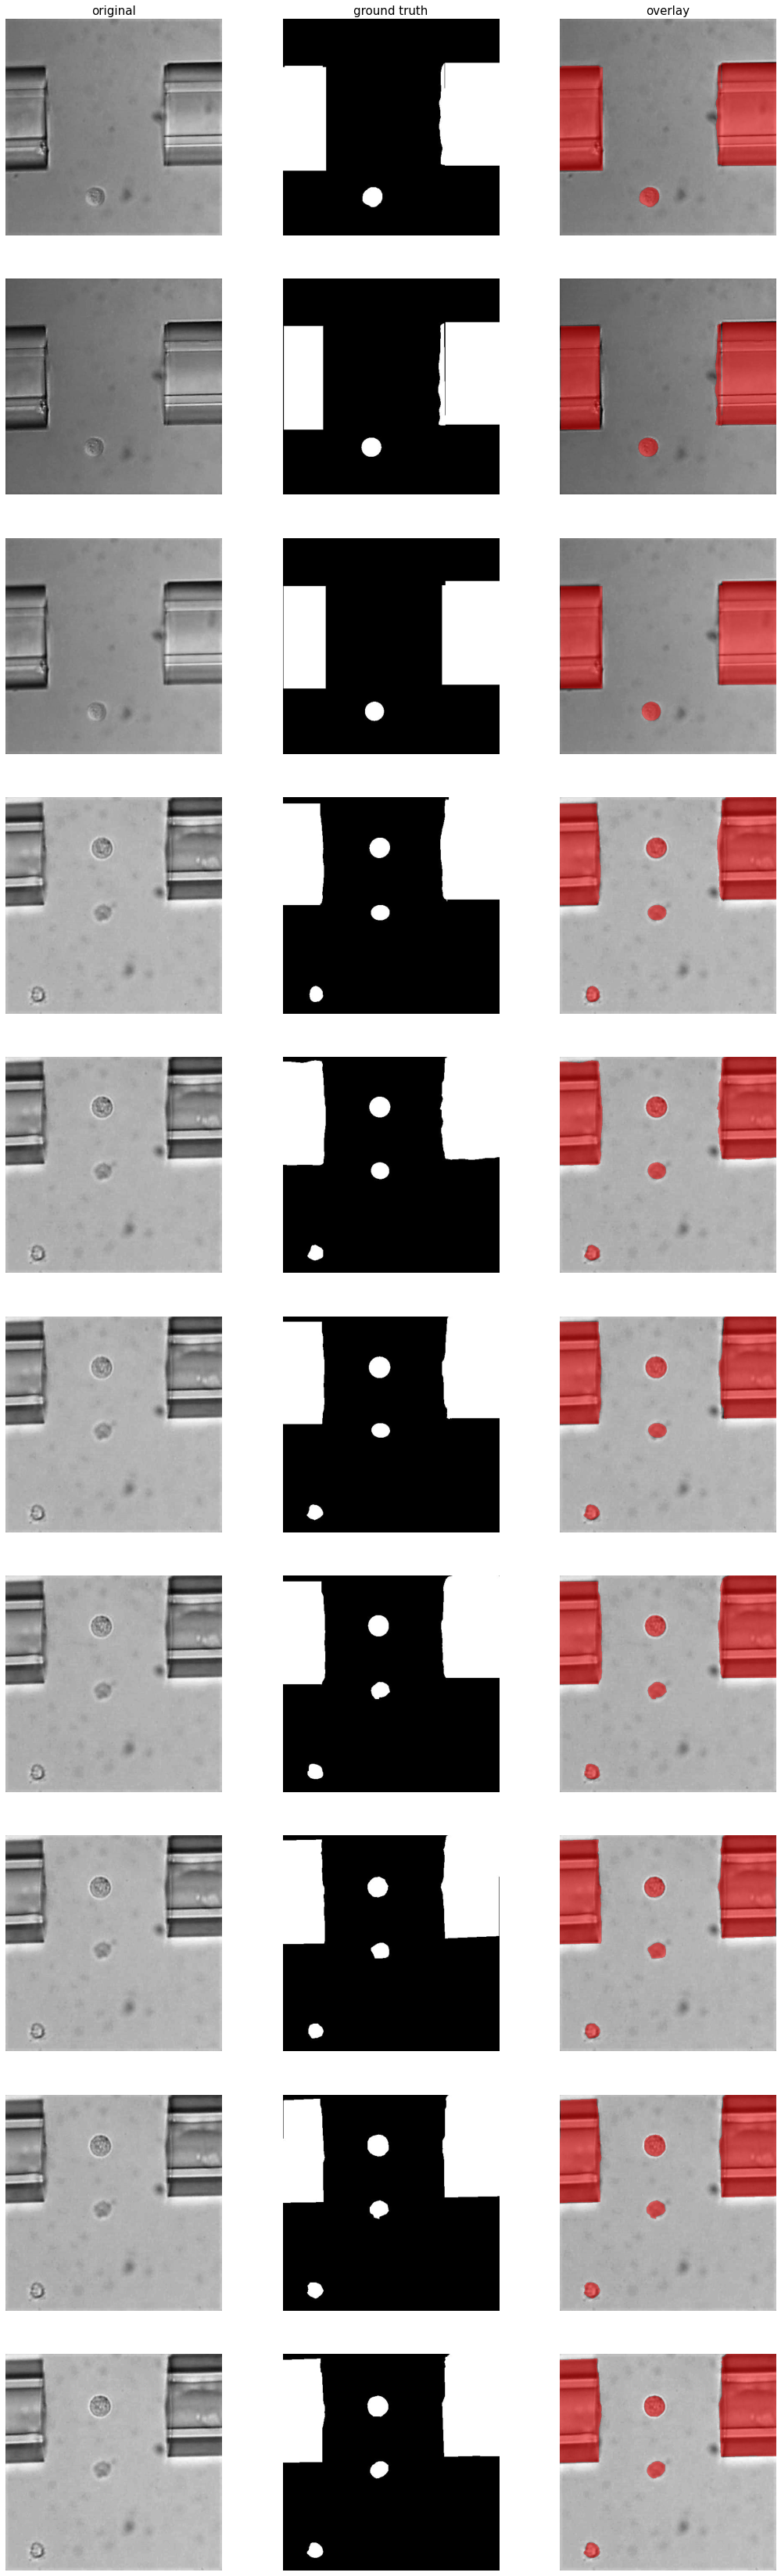

In [8]:
plot_imgs(org_imgs = dataset, mask_imgs = label, nm_img_to_plot = 10, figsize = 6)

In [9]:
ds = dataset.reshape((51,512,512,1))
lb = label.reshape((51,512,512,1))
print(ds.shape)
print(lb.shape)

(51, 512, 512, 1)
(51, 512, 512, 1)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(ds, lb, test_size = 0.3)

In [11]:
model_1 = custom_unet(input_shape=(512, 512, 1),use_batch_norm = False,
                    num_classes=1,filters=64,dropout = 0.2,
                    output_activation = 'sigmoid')

model_1.summary()   

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 512, 512, 64  0          ['conv2d[0][0]']                 
 out2D)                         )                                                             

In [12]:
model_1.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=0.01, momentum = 0.99),         
              metrics=[iou,iou_thresholded])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:
from keras_unet.utils import get_augmented

train_generator = get_augmented(x_train,y_train, batch_size = 2,
                               data_gen_args = dict(
                               rotation_range=15,width_shift_range=0.05,
                               height_shift_range=0.05,
                               shear_range=50,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='constant'))


In [14]:
model_1.fit_generator(train_generator,
                    steps_per_epoch=10,
                    epochs=100,
                    validation_data = (x_test,y_test),
                    # callbacks=[es_monitor]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/100
10/10 [==============================] - 54s 5s/step - loss: 0.5178 - iou: 0.0954 - iou_thresholded: 0.0178 - val_loss: 0.4920 - val_iou: 0.1372 - val_iou_thresholded: 1.0489e-06
Epoch 2/100
10/10 [==============================] - 50s 5s/step - loss: 0.4522 - iou: 0.0977 - iou_thresholded: 1.8426e-05 - val_loss: 0.5636 - val_iou: 0.1010 - val_iou_thresholded: 1.0489e-06
Epoch 3/100
10/10 [==============================] - 52s 5s/step - loss: 0.4453 - iou: 0.0764 - iou_thresholded: 1.3717e-05 - val_loss: 0.5017 - val_iou: 0.1507 - val_iou_thresholded: 1.0489e-06
Epoch 4/100
10/10 [==============================] - 50s 5s/step - loss: 0.4549 - iou: 0.1118 - iou_thresholded: 1.3710e-05 - val_loss: 0.5036 - val_iou: 0.1297 - val_iou_thresholded: 1.0489e-06
Epoch 5/100
10/10 [==============================] - 51s 5s/step - loss: 0.4142 - iou: 0.0844 - iou_thresholded: 1.3018e-05 - val_loss: 0.5324 - val_iou: 0.1079 - val_iou_thresholded: 1.0489e-06
Epoch 6/100
10/10 [==========

In [15]:
predicted = model_1.predict(x_test)  
print(predicted.shape)
scores = model_1.evaluate(x_test, y_test, verbose=0)
print(scores)
predicted = predicted.reshape((x_test.shape[0],512,512))
y_test = y_test.reshape((x_test.shape[0],512,512))
print(predicted.shape)
print(y_test.shape)

(16, 512, 512, 1)
[0.1513323187828064, 0.6372568011283875, 0.6811755895614624]
(16, 512, 512)
(16, 512, 512)


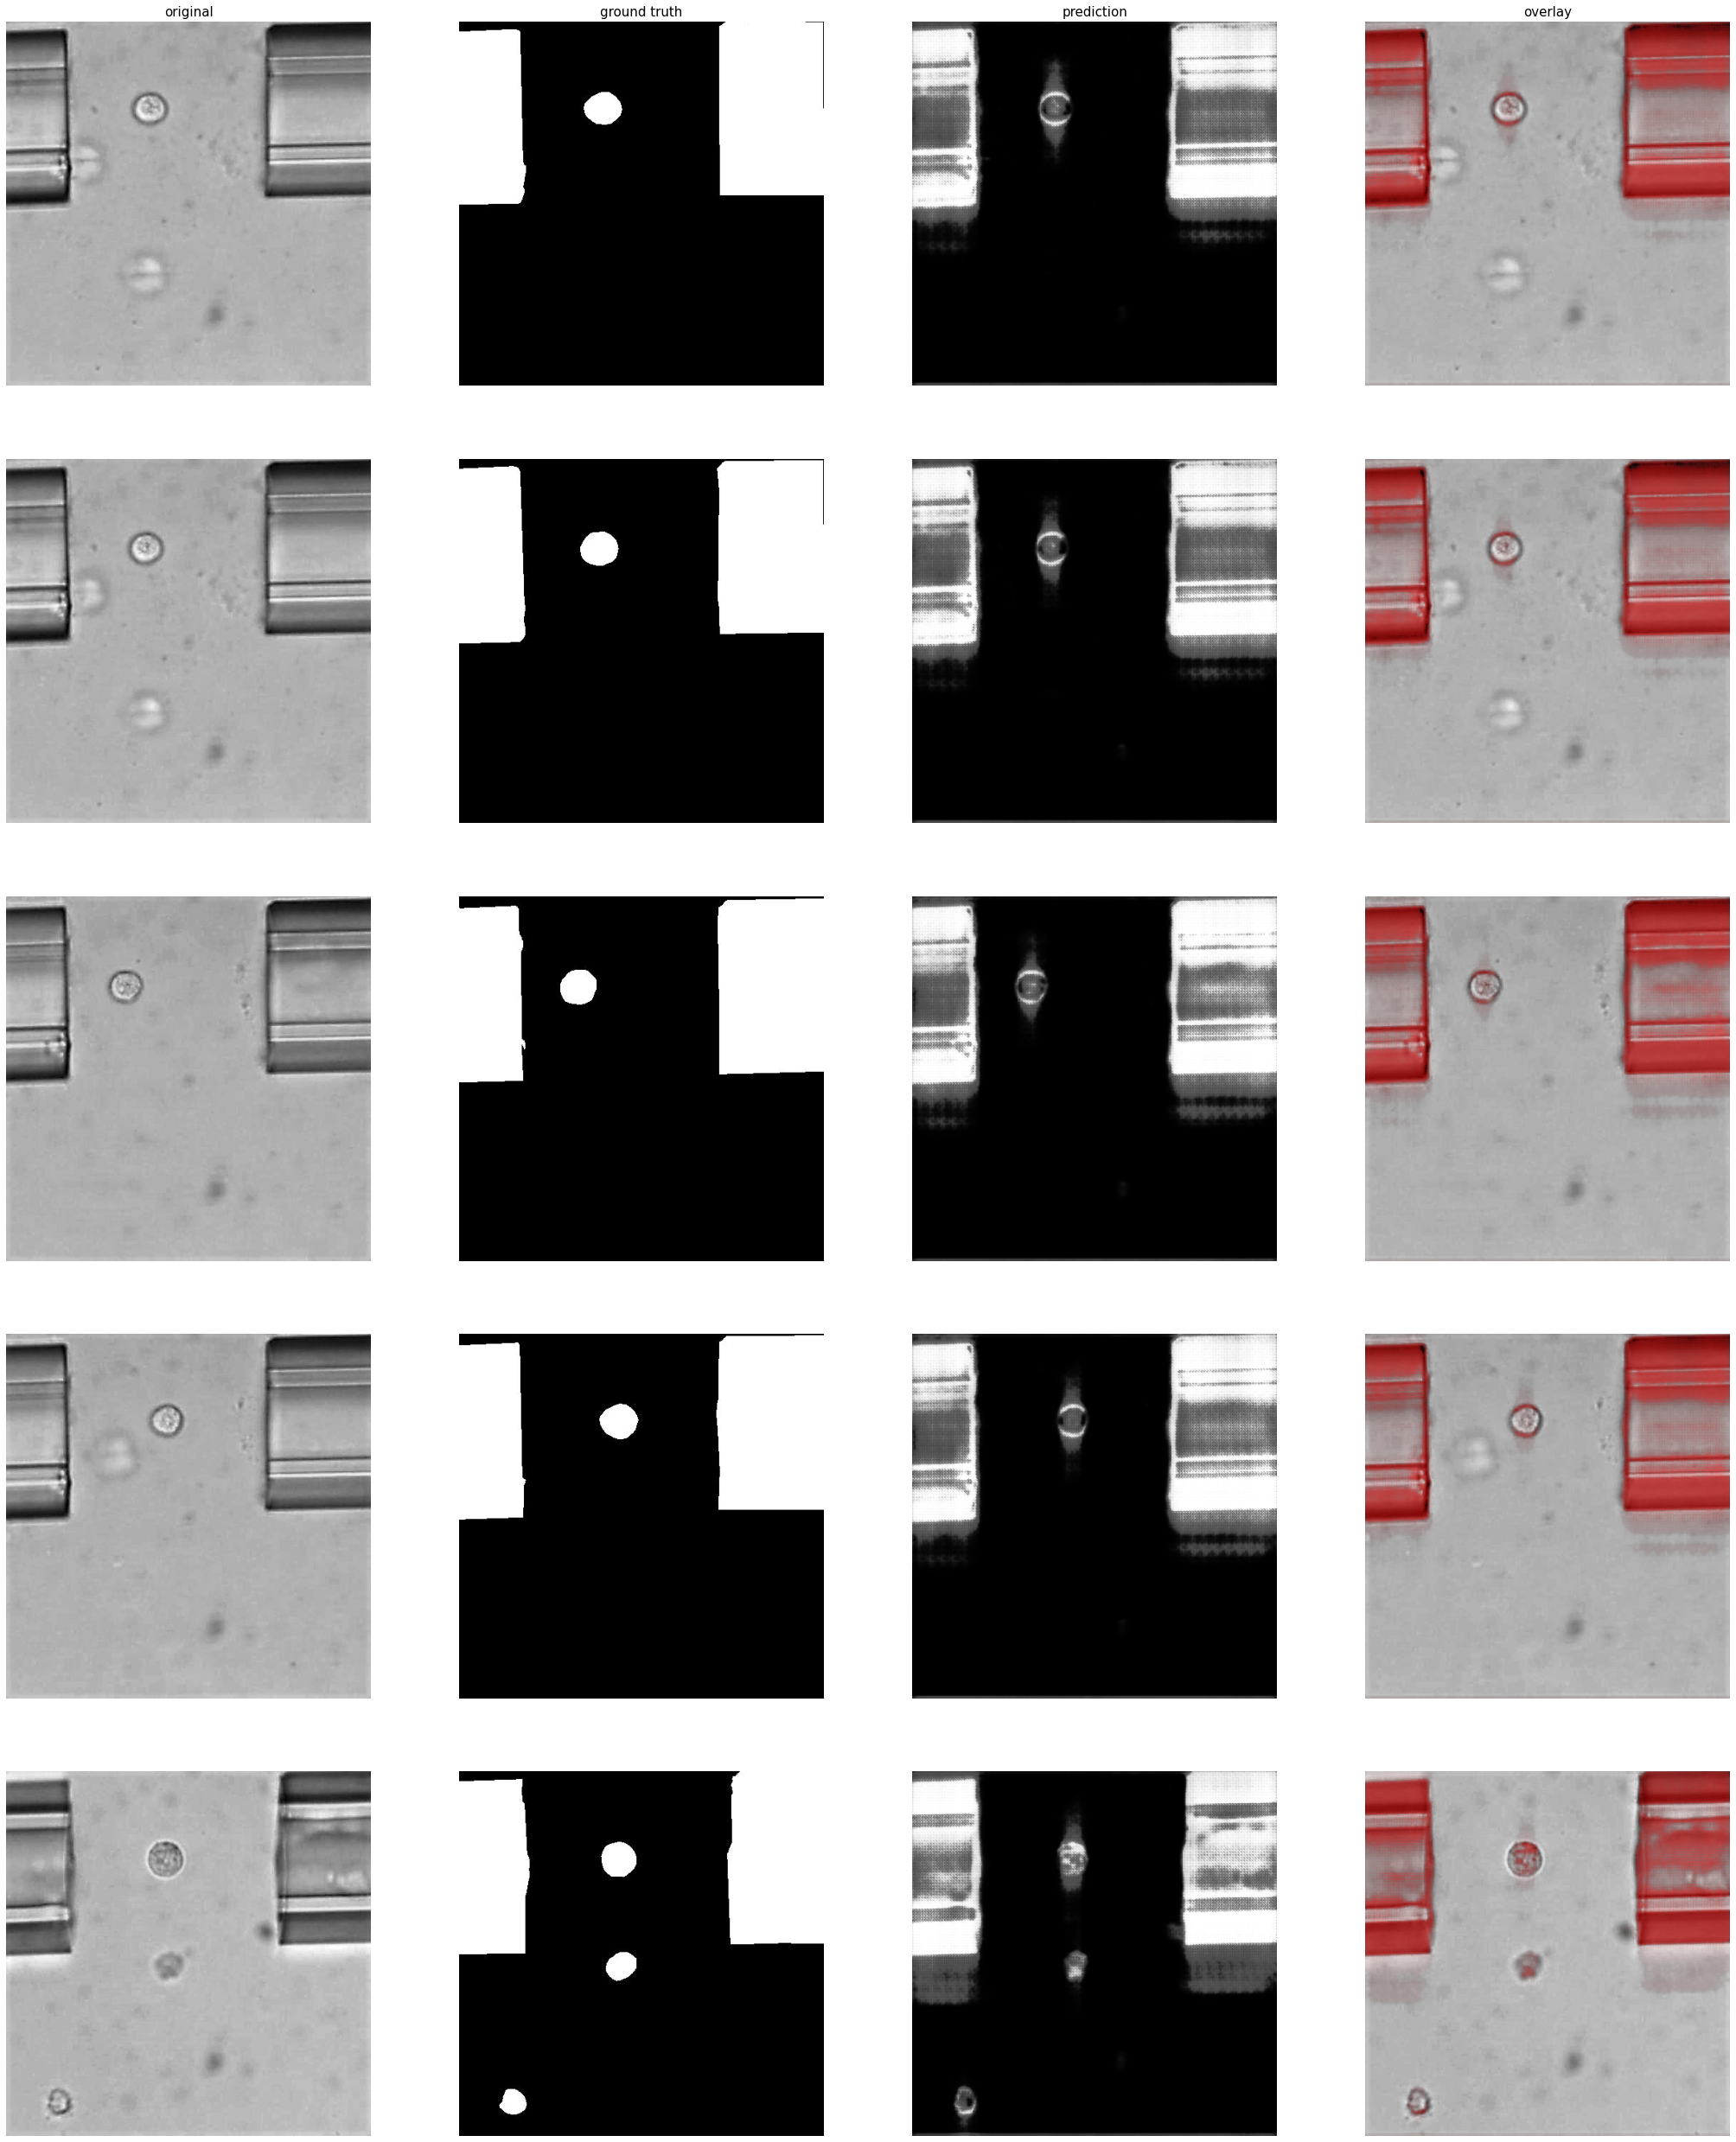

In [16]:
plot_imgs(org_imgs = x_test, mask_imgs = y_test, pred_imgs = predicted, nm_img_to_plot = 5, figsize = 9)

In [18]:
model_1.save('/content/drive/MyDrive/Cancer_Dectetin/INPUT_OFICIAL/Model_Gene_51.h5') 

### ***Test the model in images *** 

In [19]:
# model_1 = load_model('/content/drive/MyDrive/Cancer_Dectetin/INPUT_OFICIAL/T_Model_Gene_51.h5')

In [23]:
cancer  = np.zeros([512,512])
image_directory = '/content/drive/MyDrive/Cancer_Dectetin/INPUT_OFICIAL/TEST/TEST_A'
SIZE = 512


Error = os.listdir(image_directory)
for a in Error:    #Remember enumerate method adds a counter and returns the enumerate object
    image = Image.open(image_directory + '/' + a)
    image = image.convert('L') 
    image = image.resize((SIZE,SIZE))
    image = asarray(image)
    image = image/255
    cancer = np.append(cancer,image,axis = 0)


print(len(cancer))
print(cancer.shape)
cancer = cancer.reshape((22,512,512,1))
print(cancer.shape)
cancer = np.delete(cancer,0,0)
print(cancer.shape)


11264
(11264, 512)
(22, 512, 512, 1)
(21, 512, 512, 1)


In [24]:
predicted_1 = model_1.predict(cancer)  
print(predicted_1.shape)
predicted = predicted_1.reshape((cancer.shape[0],512,512))
cancer = cancer.reshape((cancer.shape[0],512,512))
print(predicted.shape)
print(cancer.shape)

(21, 512, 512, 1)
(21, 512, 512)
(21, 512, 512)


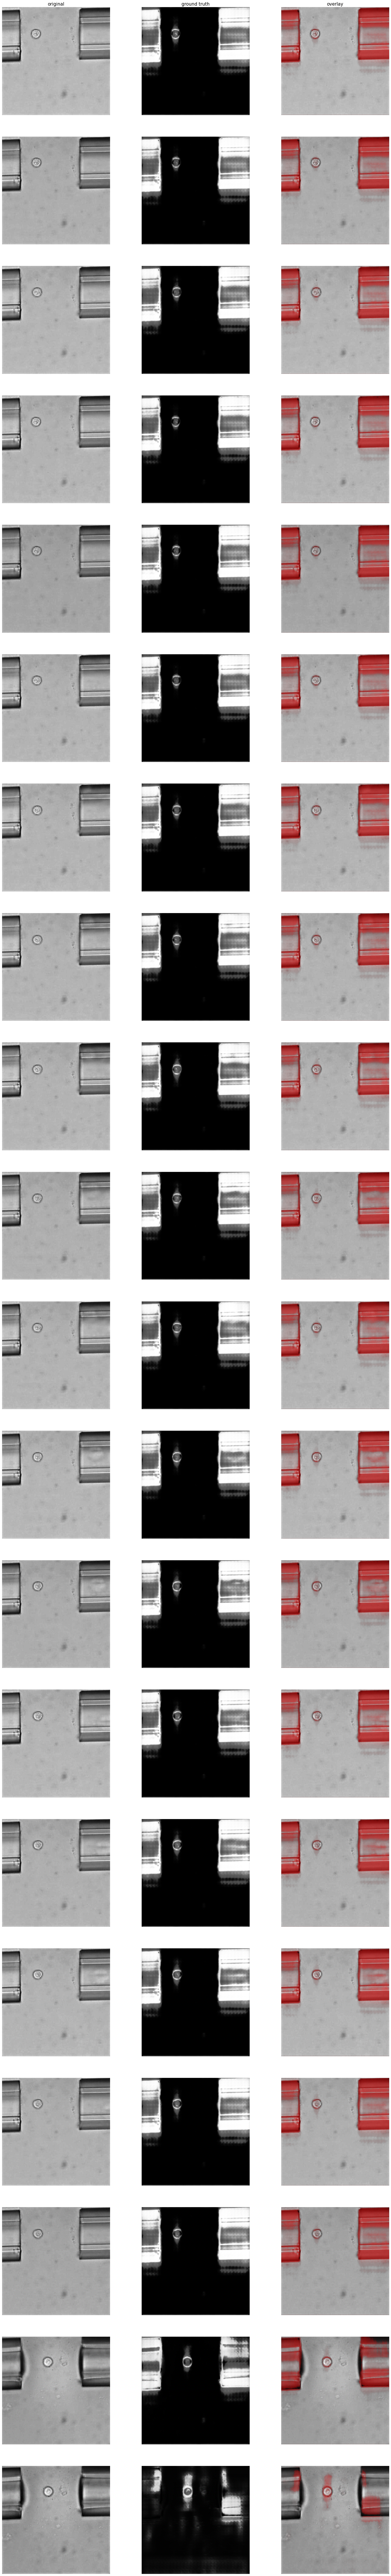

In [25]:
plot_imgs(org_imgs = cancer, mask_imgs = predicted, nm_img_to_plot = 20, figsize = 8)